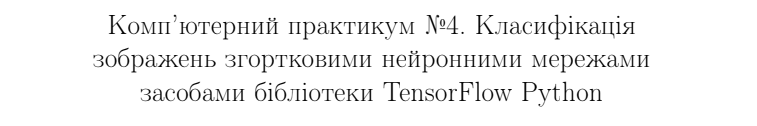

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow_addons.metrics import F1Score
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import TensorBoard
import os, datetime

Для того, щоб можна було запускати TensorBoard

In [2]:
%load_ext tensorboard

In [3]:
import hub

ds = hub.load("hub://activeloop/kuzushiji-kanji")

/home/nerbivol/.local/lib/python3.10/site-packages/hub/util/check_latest_version.py:32: UserWarning: A newer version of hub (2.5.1) is available. It's recommended that you update to the latest version using `pip install -U hub`.
  warnings.warn(


Opening dataset in read-only mode as you don't have write permissions.
hub://activeloop/kuzushiji-kanji loaded successfully.
This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/kuzushiji-kanji


In [4]:
X = ds.images[0:25000].numpy() 
Y = ds.labels[0:25000].numpy()

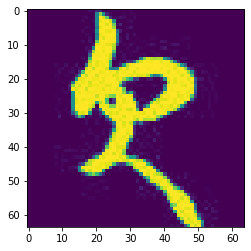

In [5]:
plt.imshow(X[5])

In [6]:
from sklearn import preprocessing

ohe = preprocessing.OneHotEncoder()

ohe.fit(Y)
y = ohe.transform(Y).toarray()

In [7]:
y.shape

(25000, 652)

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state=1)

In [9]:
X_train = X_train / 255.0
X_valid = X_valid / 255.0

In [10]:
print("Training matrix shape", X_train.shape)
print("Valid matrix shape", X_valid.shape)
print("Train features shape", y_train.shape)
print("Valid features shape", y_valid.shape)

Training matrix shape (20000, 64, 64)
Valid matrix shape (5000, 64, 64)
Train features shape (20000, 652)
Valid features shape (5000, 652)


In [12]:
fit_params = {
    'x': X_train,
    'y': y_train,
    'validation_data': (X_valid, y_valid),
}

### Baseline model

In [21]:
base_model = keras.Sequential([
    layers.Conv2D(filters=32, kernel_size=(5, 5), strides=(1, 1),
           padding="same", activation='relu', input_shape=(64, 64, 1)),
    layers.MaxPool2D(),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(units=652, activation='softmax')
  ]
)

In [22]:
base_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 64, 64, 32)        832       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 32768)             0         
                                                                 
 dense_6 (Dense)             (None, 256)               8388864   
                                                                 
 dense_7 (Dense)             (None, 652)               167564    
                                                                 
Total params: 8,557,260
Trainable params: 8,557,260
Non-trainable params: 0
____________________________________________

In [23]:
base_model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=['accuracy']
)

history = base_model.fit(X_train,y_train, 
                        validation_data=(X_valid, y_valid),
                        epochs=30)

2022-06-03 10:44:35.336418: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 327680000 exceeds 10% of free system memory.
2022-06-03 10:44:36.132944: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 52160000 exceeds 10% of free system memory.


Epoch 1/30
625/625 [==============================] - 50s 76ms/step - loss: 2.2392 - accuracy: 0.6080 - val_loss: 1.4953 - val_accuracy: 0.7278
Epoch 2/30
625/625 [==============================] - 51s 81ms/step - loss: 0.7964 - accuracy: 0.8397 - val_loss: 1.1949 - val_accuracy: 0.7864
Epoch 3/30
625/625 [==============================] - 47s 76ms/step - loss: 0.2360 - accuracy: 0.9446 - val_loss: 1.2913 - val_accuracy: 0.7772
Epoch 4/30
625/625 [==============================] - 54s 86ms/step - loss: 0.0594 - accuracy: 0.9840 - val_loss: 1.5821 - val_accuracy: 0.7886
Epoch 5/30
625/625 [==============================] - 53s 85ms/step - loss: 0.0403 - accuracy: 0.9882 - val_loss: 1.6705 - val_accuracy: 0.7846
Epoch 6/30
625/625 [==============================] - 48s 76ms/step - loss: 0.0412 - accuracy: 0.9875 - val_loss: 1.7421 - val_accuracy: 0.7820
Epoch 7/30
625/625 [==============================] - 48s 77ms/step - loss: 0.0497 - accuracy: 0.9856 - val_loss: 1.8856 - val_accuracy:

In [24]:
pd.Series({k:v[-1] for k, v in history.history.items()})

loss            0.010278
accuracy        0.996550
val_loss        2.565178
val_accuracy    0.797400
dtype: float64

In [82]:
%tensorboard --logdir logs  #для відображення TensorBoard в notebook

Як бачимо, модель є дуже перенавченою.

In [41]:
model = keras.Sequential([
    layers.Conv2D(32,kernel_size=5,
                  activation='relu',input_shape=(64,64,1)),
    layers.MaxPool2D(),
    layers.BatchNormalization(),
    layers.Conv2D(32,kernel_size=5,activation='relu'),
    layers.MaxPool2D(),
    layers.BatchNormalization(),
    layers.Conv2D(32,kernel_size=5,activation='relu'),
    layers.MaxPool2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(652, activation='softmax')
])

model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 60, 60, 32)        832       
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 30, 30, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_46 (Bat  (None, 30, 30, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_41 (Conv2D)          (None, 26, 26, 32)        25632     
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 13, 13, 32)       0         
 g2D)                                                            
                                                     

In [53]:
model.compile(optimizer="adam", 
              loss="categorical_crossentropy", 
              metrics=["accuracy"])

history = model.fit(**fit_params,
                    batch_size=64,
                    epochs=30)

Epoch 1/30
313/313 [==============================] - 73s 231ms/step - loss: 0.2249 - accuracy: 0.9323 - val_loss: 0.4584 - val_accuracy: 0.9112
Epoch 2/30
313/313 [==============================] - 70s 222ms/step - loss: 0.2194 - accuracy: 0.9339 - val_loss: 0.4572 - val_accuracy: 0.9116
Epoch 3/30
313/313 [==============================] - 61s 194ms/step - loss: 0.2026 - accuracy: 0.9401 - val_loss: 0.4476 - val_accuracy: 0.9170
Epoch 4/30
313/313 [==============================] - 82s 264ms/step - loss: 0.2056 - accuracy: 0.9372 - val_loss: 0.4567 - val_accuracy: 0.9144
Epoch 5/30
313/313 [==============================] - 107s 341ms/step - loss: 0.1899 - accuracy: 0.9416 - val_loss: 0.4567 - val_accuracy: 0.9162
Epoch 6/30
313/313 [==============================] - 77s 247ms/step - loss: 0.1830 - accuracy: 0.9427 - val_loss: 0.4474 - val_accuracy: 0.9216
Epoch 7/30
313/313 [==============================] - 61s 196ms/step - loss: 0.1797 - accuracy: 0.9459 - val_loss: 0.4612 - val_a

In [54]:
pd.Series({k:v[-1] for k, v in history.history.items()})


loss            0.133537
accuracy        0.958950
val_loss        0.469622
val_accuracy    0.921800
dtype: float64

In [83]:
def plot_loss_accuraccy(history):
    history_df = pd.DataFrame(history.history)
    print("Maximum accuracy: {}".format(history_df['val_accuracy'].max()))
    history_df[['loss', 'val_loss']].plot()
    history_df[['accuracy', 'val_accuracy']].plot()

Maximum accuracy: 0.9265999794006348


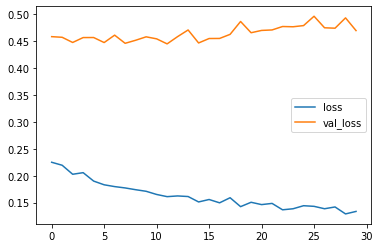

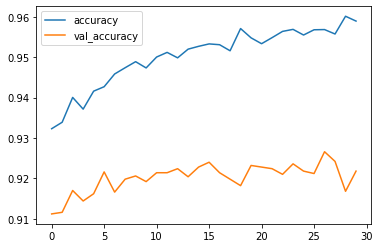

In [55]:
plot_loss_accuraccy(history)

Результат з нової моделі є набагато кращим. Порівнюючи з моделю з одним шаром згорткової моделі.

Створимо нові мережі для дослідження моделей із використанням бачнормлізації та дропаутом із різними коефіцієнтами:

In [60]:
model = [0] * 3
res = pd.DataFrame()

for i in range(1, 4):

    model[i] = keras.Sequential([
    layers.Conv2D(32,kernel_size=5,
                  activation='relu',input_shape=(64,64,1)),
    layers.MaxPool2D(),
    layers.BatchNormalization(),
    layers.Conv2D(32,kernel_size=5,activation='relu'),
    layers.MaxPool2D(),
    layers.BatchNormalization(),
    layers.Conv2D(32,kernel_size=5,activation='relu'),
    layers.MaxPool2D(),
    layers.BatchNormalization(),
    layers.Dropout(i*0.2),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(i*0.2),
    layers.Dense(652, activation='softmax')
])
    
    model[i].compile(optimizer="adam",
                     loss="categorical_crossentropy", 
                     metrics=["accuracy"])
    
    logdir = os.path.join("logs/lab4/drop", str(i*0.2))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

    
    history = model[i].fit(**fit_params,
                           epochs=30,
                           callbacks=[tensorboard_callback]
                          )
    
    res[f'p={i*0.2}'] = pd.Series({i:j[-1] for i, j in history.history.items()})
    
    model[i].save(f'models/lab4/drop{i*0.2}')

Epoch 1/30
625/625 [==============================] - 73s 96ms/step - loss: 2.3616 - accuracy: 0.5972 - val_loss: 1.2850 - val_accuracy: 0.7536
Epoch 2/30
625/625 [==============================] - 60s 95ms/step - loss: 0.8245 - accuracy: 0.8351 - val_loss: 0.8072 - val_accuracy: 0.8354
Epoch 3/30
625/625 [==============================] - 60s 95ms/step - loss: 0.3997 - accuracy: 0.9156 - val_loss: 0.6097 - val_accuracy: 0.8764
Epoch 4/30
625/625 [==============================] - 60s 96ms/step - loss: 0.2045 - accuracy: 0.9571 - val_loss: 0.5732 - val_accuracy: 0.8852
Epoch 5/30
625/625 [==============================] - 60s 96ms/step - loss: 0.1064 - accuracy: 0.9788 - val_loss: 0.5789 - val_accuracy: 0.8804
Epoch 6/30
625/625 [==============================] - 60s 96ms/step - loss: 0.0608 - accuracy: 0.9893 - val_loss: 0.5407 - val_accuracy: 0.8930
Epoch 7/30
625/625 [==============================] - 60s 97ms/step - loss: 0.0433 - accuracy: 0.9927 - val_loss: 0.5653 - val_accuracy:

2022-06-03 16:41:44.943695: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/lab4/drop0.0/assets
Assets written to: models/lab4/drop0.0/assets
Epoch 1/30
625/625 [==============================] - 378s 425ms/step - loss: 2.7115 - accuracy: 0.5347 - val_loss: 1.5282 - val_accuracy: 0.7136
Epoch 2/30
625/625 [==============================] - 77s 123ms/step - loss: 1.1918 - accuracy: 0.7586 - val_loss: 0.9169 - val_accuracy: 0.8136
Epoch 3/30
625/625 [==============================] - 86s 138ms/step - loss: 0.7375 - accuracy: 0.8372 - val_loss: 0.6986 - val_accuracy: 0.8580
Epoch 4/30
625/625 [==============================] - 64s 102ms/step - loss: 0.5067 - accuracy: 0.8811 - val_loss: 0.5886 - val_accuracy: 0.8760
Epoch 5/30
625/625 [==============================] - 69s 110ms/step - loss: 0.3731 - accuracy: 0.9075 - val_loss: 0.5453 - val_accuracy: 0.8840
Epoch 6/30
625/625 [==============================] - 67s 107ms/step - loss: 0.2876 - accuracy: 0.9255 - val_loss: 0.5257 - val_accuracy: 0.8948
Epoch 7/30
625/625 [=

Epoch 26/30
625/625 [==============================] - 60s 96ms/step - loss: 0.2439 - accuracy: 0.9283 - val_loss: 0.4873 - val_accuracy: 0.9102
Epoch 27/30
625/625 [==============================] - 60s 96ms/step - loss: 0.2476 - accuracy: 0.9266 - val_loss: 0.4800 - val_accuracy: 0.9120
Epoch 28/30
625/625 [==============================] - 60s 96ms/step - loss: 0.2357 - accuracy: 0.9289 - val_loss: 0.4824 - val_accuracy: 0.9110
Epoch 29/30
625/625 [==============================] - 60s 97ms/step - loss: 0.2376 - accuracy: 0.9293 - val_loss: 0.4828 - val_accuracy: 0.9156
Epoch 30/30
625/625 [==============================] - 61s 97ms/step - loss: 0.2302 - accuracy: 0.9318 - val_loss: 0.4884 - val_accuracy: 0.9122
INFO:tensorflow:Assets written to: models/lab4/drop0.4/assets
Assets written to: models/lab4/drop0.4/assets


In [61]:
res

,p=0.0,p=0.2,p=0.4
loss,0.017953,0.057658,0.230169
accuracy,0.994600,0.981800,0.931800
val_loss,0.774908,0.596816,0.488401
val_accuracy,0.891400,0.907200,0.912200


Найкращу модель отримали при коефіцієнті дропауту, який дорівнює 0.4

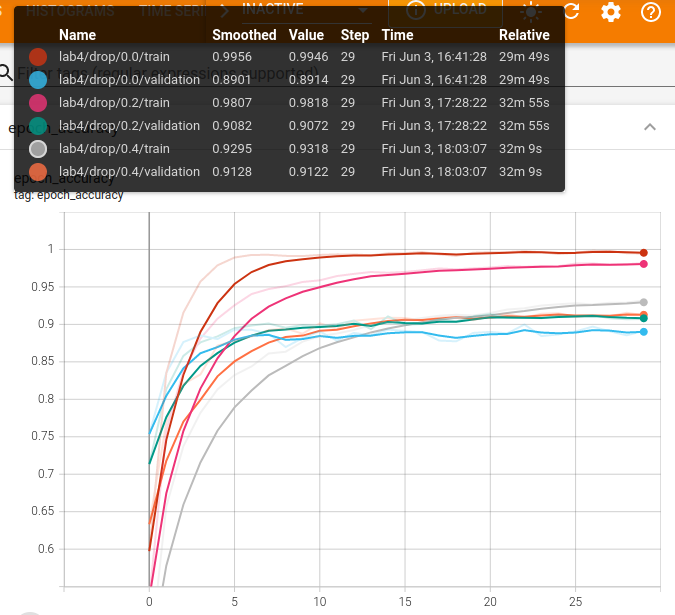
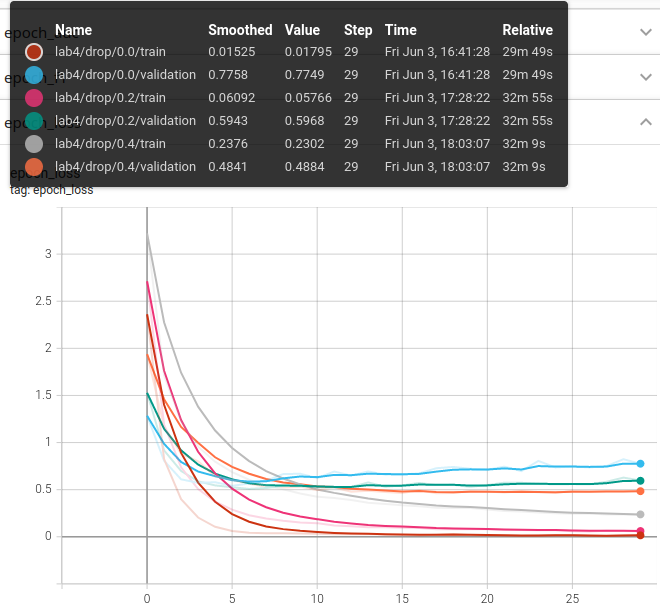

Дослідимо, як впливає розмір ядра згорти на навчання моделі.

In [62]:
kernel_sizes = [1, 3, 10, 30]

model_kernel = [0] * 4
kernel_res = pd.DataFrame()
kernel_res["kernel_size=5"] = res["p=0.4"]

for kernel_size in kernel_sizes:

    model_kernel[kernel_size] = keras.Sequential([
    layers.Conv2D(32,kernel_size=kernel_size,
                  activation='relu',input_shape=(64,64,1)),
    layers.MaxPool2D(),
    layers.BatchNormalization(),
    layers.Conv2D(32,kernel_size=kernel_size,activation='relu'),
    layers.MaxPool2D(),
    layers.BatchNormalization(),
    layers.Conv2D(32,kernel_size=kernel_size,activation='relu'),
    layers.MaxPool2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(652, activation='softmax')
])
    
    model_kernel[kernel_size].compile(optimizer="adam",
                     loss="categorical_crossentropy", 
                     metrics=["accuracy"])
    
    logdir = os.path.join("logs/lab4/kernel", str(kernel_size))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

    
    history = model_kernel[kernel_size].fit(**fit_params,
                                       epochs=30,
                                       callbacks=[tensorboard_callback]
                                      )
    
    kernel_res[f'kernel_size={kernel_size}'] = pd.Series({i:j[-1] for i, j in history.history.items()})
    
    model_kernel[kernel_size].save(f'models/lab4/kernel{kernel_size}')

Epoch 1/30
625/625 [==============================] - 28s 43ms/step - loss: 3.1559 - accuracy: 0.4518 - val_loss: 2.2176 - val_accuracy: 0.5574
Epoch 2/30
625/625 [==============================] - 26s 42ms/step - loss: 2.0181 - accuracy: 0.5868 - val_loss: 1.7482 - val_accuracy: 0.6392
Epoch 3/30
625/625 [==============================] - 32s 51ms/step - loss: 1.6737 - accuracy: 0.6349 - val_loss: 1.8590 - val_accuracy: 0.6160
Epoch 4/30
625/625 [==============================] - 31s 49ms/step - loss: 1.4776 - accuracy: 0.6639 - val_loss: 1.8184 - val_accuracy: 0.6300
Epoch 5/30
625/625 [==============================] - 28s 44ms/step - loss: 1.3516 - accuracy: 0.6867 - val_loss: 1.3261 - val_accuracy: 0.7224
Epoch 6/30
625/625 [==============================] - 28s 45ms/step - loss: 1.2512 - accuracy: 0.7018 - val_loss: 1.3655 - val_accuracy: 0.7146
Epoch 7/30
625/625 [==============================] - 28s 45ms/step - loss: 1.1823 - accuracy: 0.7114 - val_loss: 1.3929 - val_accuracy:

Epoch 27/30
625/625 [==============================] - 43s 69ms/step - loss: 0.1754 - accuracy: 0.9493 - val_loss: 0.4472 - val_accuracy: 0.9262
Epoch 28/30
625/625 [==============================] - 44s 70ms/step - loss: 0.1745 - accuracy: 0.9468 - val_loss: 0.4487 - val_accuracy: 0.9232
Epoch 29/30
625/625 [==============================] - 43s 69ms/step - loss: 0.1803 - accuracy: 0.9455 - val_loss: 0.4351 - val_accuracy: 0.9274
Epoch 30/30
625/625 [==============================] - 42s 68ms/step - loss: 0.1638 - accuracy: 0.9493 - val_loss: 0.4433 - val_accuracy: 0.9230
INFO:tensorflow:Assets written to: models/lab4/kernel3/assets
Assets written to: models/lab4/kernel3/assets


ValueError: Exception encountered when calling layer "conv2d_68" (type Conv2D).

Negative dimension size caused by subtracting 10 from 9 for '{{node conv2d_68/Conv2D}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](Placeholder, conv2d_68/Conv2D/ReadVariableOp)' with input shapes: [?,9,9,32], [10,10,32,32].

Call arguments received:
  • inputs=tf.Tensor(shape=(None, 9, 9, 32), dtype=float32)

In [63]:
kernel_res

,kernel_size=5,kernel_size=1,kernel_size=3
loss,0.230169,0.744660,0.163801
accuracy,0.931800,0.796350,0.949350
val_loss,0.488401,1.549692,0.443342
val_accuracy,0.912200,0.698000,0.923000


Модель із kernel_size = 3 є кращою, ніж та модель, що ми використовували раніше із kernel_size = 5. Також бачимо, що для даної моделі не підходять дуже велиі значення розміру ядра згорти. Варто зауважити, що змінився і час навчання моделі. При меншому розмірі ядра і менший час навчання.

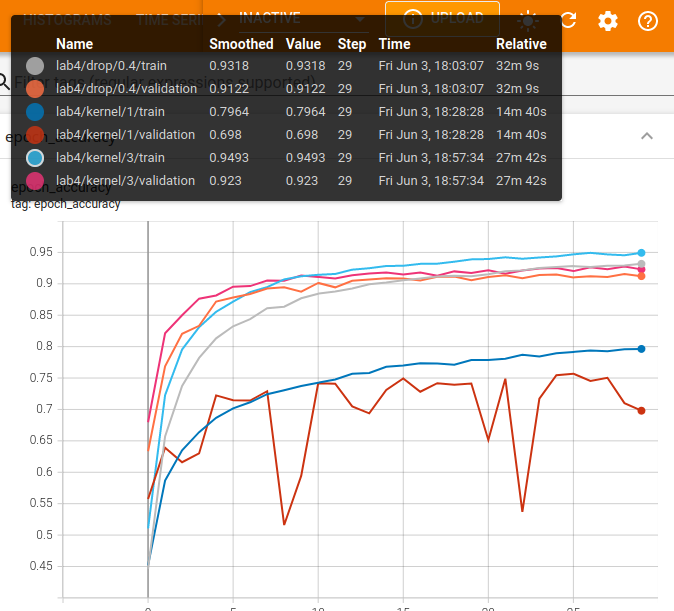
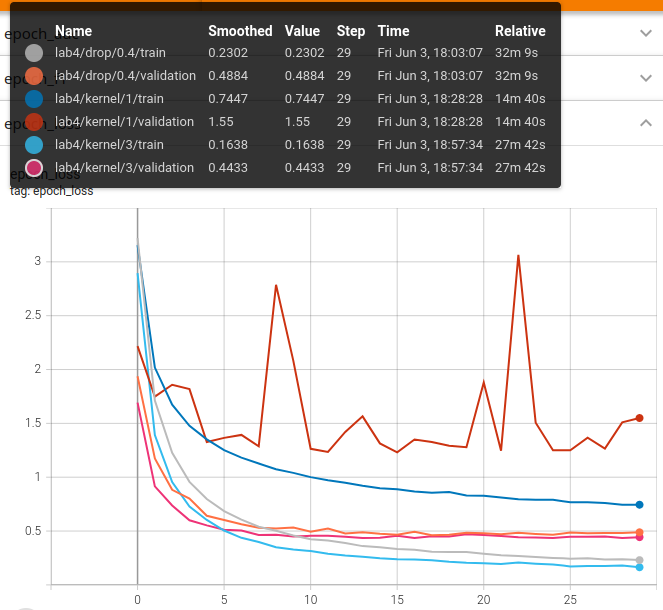

На графіках також помітно, що при параметрі kernel=1 отримуюються дуже непердбачувані результати. Точність такої мережі коливається від 0.5 до 0.75 відносно епохи навчання. Такий варіант навчання є ненадійним і не може використовуватися при навчання моделі.

Дослідимо дану модель із параметром padding = same

In [64]:
model_same= keras.Sequential([
    layers.Conv2D(32,kernel_size=3,
                  activation='relu',input_shape=(64,64,1),padding = "same"),
    layers.MaxPool2D(),
    layers.BatchNormalization(),
    layers.Conv2D(32,kernel_size=3,activation='relu',padding = "same"),
    layers.MaxPool2D(),
    layers.BatchNormalization(),
    layers.Conv2D(32,kernel_size=3,activation='relu',padding = "same"),
    layers.MaxPool2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(652, activation='softmax')
])
    
model_same.compile(optimizer="adam",
              loss="categorical_crossentropy", 
              metrics=["accuracy"])
    
logdir = os.path.join("logs/lab4/same")
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

    
history_same = model_same.fit(**fit_params,
                    epochs=30,
                    callbacks=[tensorboard_callback]
                   )

model_same.save('models/lab4/same')

Epoch 1/30
625/625 [==============================] - 46s 66ms/step - loss: 2.6588 - accuracy: 0.5514 - val_loss: 1.4441 - val_accuracy: 0.7288
Epoch 2/30
625/625 [==============================] - 42s 67ms/step - loss: 1.2094 - accuracy: 0.7602 - val_loss: 0.8273 - val_accuracy: 0.8358
Epoch 3/30
625/625 [==============================] - 43s 69ms/step - loss: 0.7951 - accuracy: 0.8286 - val_loss: 0.6080 - val_accuracy: 0.8748
Epoch 4/30
625/625 [==============================] - 42s 68ms/step - loss: 0.5897 - accuracy: 0.8636 - val_loss: 0.5238 - val_accuracy: 0.8908
Epoch 5/30
625/625 [==============================] - 43s 69ms/step - loss: 0.4656 - accuracy: 0.8854 - val_loss: 0.4877 - val_accuracy: 0.8994
Epoch 6/30
625/625 [==============================] - 43s 68ms/step - loss: 0.3828 - accuracy: 0.9011 - val_loss: 0.4552 - val_accuracy: 0.9070
Epoch 7/30
625/625 [==============================] - 48s 76ms/step - loss: 0.3173 - accuracy: 0.9152 - val_loss: 0.4518 - val_accuracy:

In [70]:
pd.Series({i:j[-1] for i, j in history_same.history.items()})

loss            0.106416
accuracy        0.966350
val_loss        0.462031
val_accuracy    0.929000
dtype: float64

Модель із параметром padding='same' має кращий результат, ніж padding='valid', тому будемо використовувати параметр 'same'.

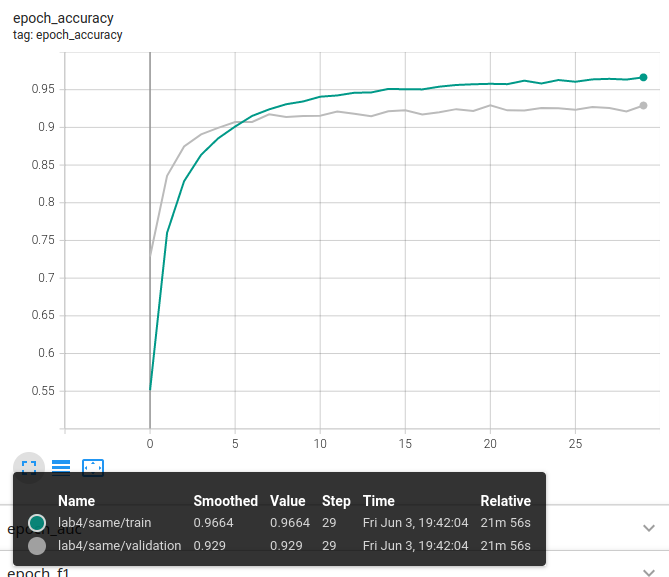
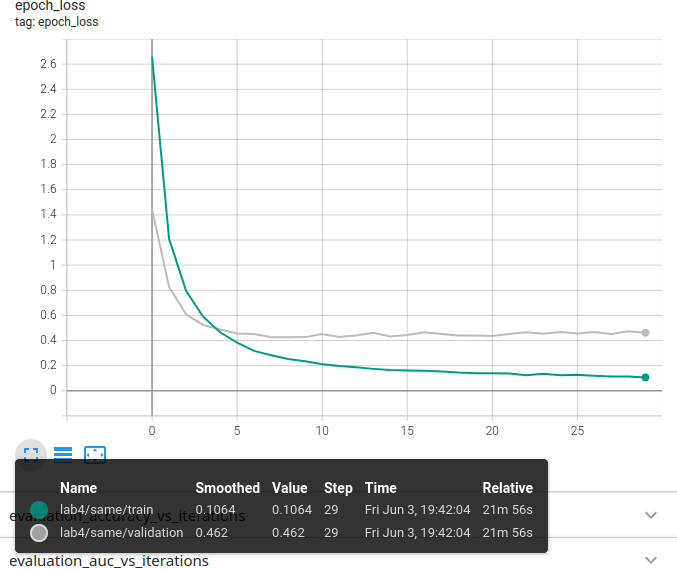

Далі проведемо аналіз параметра strides. Stride – це кількість зсувів пікселів над вхідною матрицею. Коли крок дорівнює 1, ми переміщаємо фільтри на 1 піксель за раз. Коли крок дорівнює 2, ми переміщаємо фільтри на 2 пікселі за раз і так далі. 

In [80]:
model_stride = keras.Sequential([
        layers.Conv2D(32,kernel_size=3,
                      activation='relu',input_shape=(64,64,1), 
                      strides=2, padding='same',),
        layers.MaxPool2D(),
        layers.BatchNormalization(),
        layers.Conv2D(32,kernel_size=3,activation='relu',
                     strides=2, padding='same'),
        layers.MaxPool2D(),
        layers.BatchNormalization(),
        layers.Conv2D(32,kernel_size=3,activation='relu',
                     strides=2, padding='same'),
        layers.MaxPool2D(),
        layers.BatchNormalization(),
        layers.Dropout(0.4),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(652, activation='softmax')
    ])
    
model_stride.compile(optimizer="adam",
                     loss="categorical_crossentropy", 
                     metrics=["accuracy"])
    
logdir = os.path.join("logs/lab4/stride")
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

    
history = model_stride.fit(**fit_params,
                            epochs=30,
                            callbacks=[tensorboard_callback]
                            )
    
model_stride.save(f'models/lab4/stride')

Epoch 1/30
625/625 [==============================] - 15s 19ms/step - loss: 3.9324 - accuracy: 0.3143 - val_loss: 2.8211 - val_accuracy: 0.4566
Epoch 2/30
625/625 [==============================] - 8s 13ms/step - loss: 2.7140 - accuracy: 0.4574 - val_loss: 2.0234 - val_accuracy: 0.5886
Epoch 3/30
625/625 [==============================] - 9s 14ms/step - loss: 2.3578 - accuracy: 0.5095 - val_loss: 1.7339 - val_accuracy: 0.6306
Epoch 4/30
625/625 [==============================] - 8s 13ms/step - loss: 2.1288 - accuracy: 0.5411 - val_loss: 1.5474 - val_accuracy: 0.6740
Epoch 5/30
625/625 [==============================] - 8s 13ms/step - loss: 1.9847 - accuracy: 0.5608 - val_loss: 1.4170 - val_accuracy: 0.6992
Epoch 6/30
625/625 [==============================] - 10s 15ms/step - loss: 1.8885 - accuracy: 0.5747 - val_loss: 1.3030 - val_accuracy: 0.7092
Epoch 7/30
625/625 [==============================] - 9s 15ms/step - loss: 1.8004 - accuracy: 0.5925 - val_loss: 1.2218 - val_accuracy: 0.72

loss            1.259117
accuracy        0.685400
val_loss        0.907900
val_accuracy    0.808000
dtype: float64

In [81]:
pd.Series({i:j[-1] for i, j in history.history.items()})

loss            1.259117
accuracy        0.685400
val_loss        0.907900
val_accuracy    0.808000
dtype: float64

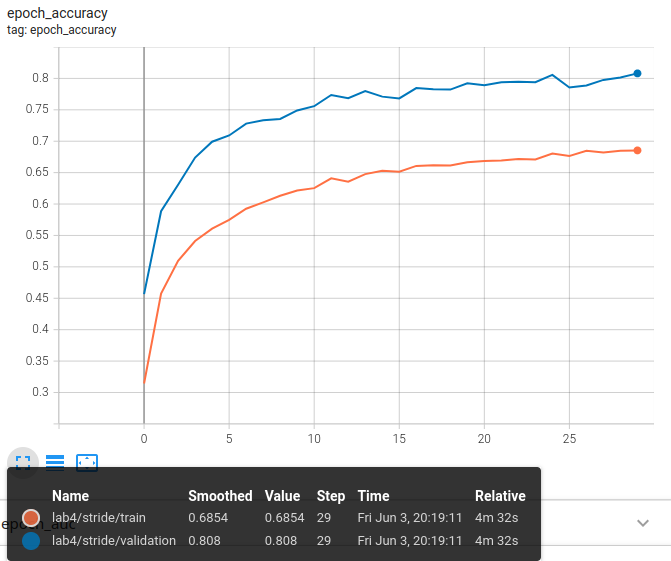
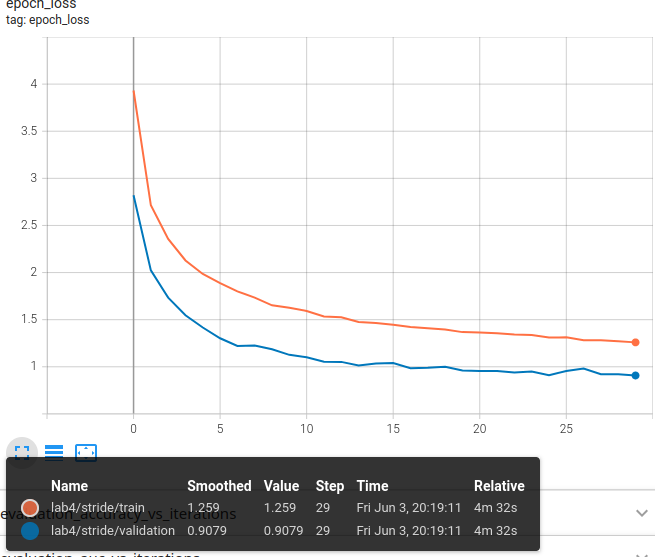

Як бачимо результат погіршився. Тому будемо використовувати попередню модель де параметр strides=1.

### Протестуємо на перевірочних даних

In [84]:
model = keras.models.load_model('models/lab4/same')

In [85]:
labels = np.unique(Y)

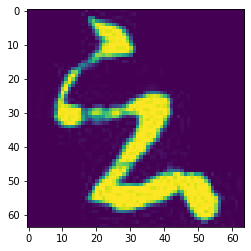

Prediction:  293
True:  293


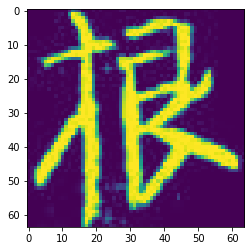

Prediction:  210
True:  210


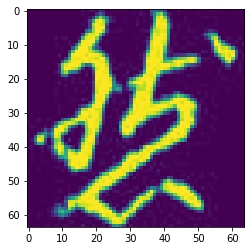

Prediction:  271
True:  271


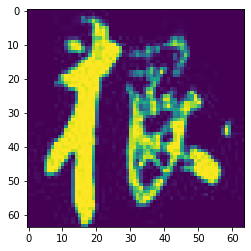

Prediction:  210
True:  210


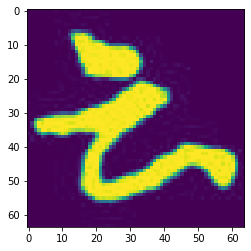

Prediction:  293
True:  293


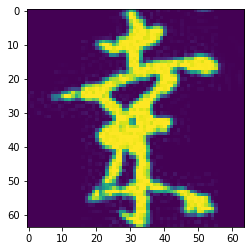

Prediction:  599
True:  599


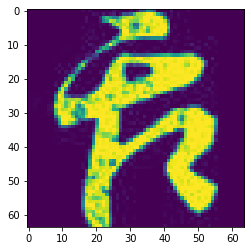

Prediction:  76
True:  76


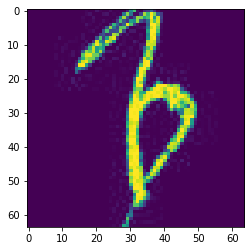

Prediction:  126
True:  126


In [88]:
indexes = np.random.randint(len(y_valid), size=8)

for l, i in enumerate(indexes):
    plt.imshow(X_valid[i].reshape(64,64))
    plt.show()
    
    prediction = model.predict(X_valid[i].reshape(-1, 64,64,1))
    print("Prediction: ", prediction.argmax())
    print("True: ", y_valid[i].argmax())

### Висновок 
Протягом даної лабораторної роботи було досліджено та побудовоні моделі на наборі даних Kuzushiji-Kanji. Після дослідження було визначено таку модель:

In [89]:
model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_69 (Conv2D)          (None, 64, 64, 32)        320       
                                                                 
 max_pooling2d_51 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_85 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_70 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_52 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                     

Під час тестування моделі не було знайденно хибно спрацьованої класифікації. Результат є дуже хорошим. Зважаючи на те що набір даних має 652 класи і велику кількість прикладів даних(для навчання було використанно лише 25000) ми маємо результат, що показує результат val_loss = 0.462031 та val_accuracy = 0.929. Звісно за допомогою згорткових мереж на даному наборі даних можна побудувати більш точну нейронну мережу. </br>
Маємо також набагато кращі результати при порівнянні мережі із попередньої лабораторної роботи дослідження mlp де результати були val_accuracy=0.8252. Тобто точність модель покращилася на 10%.